#### UXPaper Analysis
Analysis starts off with standard descriptives and general test for significance. Then goes into detail on linear mixed effects models and the discussion surrounding them. First setting up the R environment:

In [1]:
#set specific working directory
#setwd("~/Desktop/R_STUFF")

# load performance improvement libraries & enable just in time compiler
library(compiler)
enableJIT(1)

#some environmental variables (decimals)
options=7

[1] 3

In [11]:
#check if required packages are there - if not the script will install them!
requiredPackages = c('rcompanion','gdata','compiler','car','lsr','sft','nlme', 'lme4', 'bibtex', 'psych', 'likert', 'ggplot2', 'tidyverse')
for(p in requiredPackages){
  if(!require(p,character.only = TRUE)) install.packages(p);
  library(p,character.only = TRUE);
}
#load all the libraries    
lapply(requiredPackages, require, character.only = TRUE);

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

In [12]:
# Importing the data 
data <- read.xls("TimeAnalysis2_1.xlsx", verbose=FALSE, na.strings=c("NA"))

In [13]:
# quick check on the data
head(data)

ParticipantNo,ID,PDF,Order,Time,Condition,CExperience,Tasks,NReviews,AMeanNReviews,Error
1,-JjAzwjQakZk-3kIbeMfw,U2PXr4iMBf8Kt-leQI8Ii,1,435,1,1,9,10+,12.5,0
1,-JjAzwjQakZk-3kIbeMfw,4gIe5sni3WJJCzNglSdo8,2,582,0,1,9,10+,12.5,0
1,-JjAzwjQakZk-3kIbeMfw,iHbGgWtrKNfksdoj9Hxv9,3,297,1,1,9,10+,12.5,0
1,-JjAzwjQakZk-3kIbeMfw,cnDXl97I_WoVUqyIH0HbQ,4,610,0,1,9,10+,12.5,0
2,hNQKTiKtHSY_BmxLyZb9Q,XOCbiBddVQK3BYy1Ox4lI,1,306,1,1,8,5to10,7.5,0
2,hNQKTiKtHSY_BmxLyZb9Q,oOAy7INgRLumTV3vZWtVM,2,127,1,1,8,5to10,7.5,0


Short comments on the data:<br>
<b>ID</b> = individual participant<br>
<b>PDF</b> = document ID<br>
<b>Order</b> = document order of appearance<br>
<b>Time</b> = Time spent on one document in seconds<br>
<b>Condition</b> = Independent variable (1 = Machine learning recommendations (MLR) present, 0 = no MLR)<br>
<b>CExperience</b> = Experience with Cochrance Risk of Bias Tool? (1 = Yes, 0 = No)<br>
<b>Tasks</b> = Number of tasks (in a systematic review) performed (9 = max)<br>
<b>NReviews</b> = Number of systematic reviews performed<br>
<b>AMeanNReviews</b> = Artithmetic Mean number of systematic reviews performed (0=0, 1-5=3, 5-10=7.5, 10+=12.5)<br>
<b>Error</b> = reported errors (ignore for now)<br>

#### Results

In [14]:
# quick note: we had 41 participants as we were only interested in people who had experience
# in the Chocrane Risk of Bias Tool and Systematic review experience we removed the ones that
# did not have experience (41-3 people = 38 participants in total)

The analysis in this study is of parametric data (timing-data). As this analysis is looking for differences between the two groups (MLR and NMLR) a paired samples t-test is the suitable test for an initial overview of the data.<br>
(Note: Initially I used a Wilcoxon Test as I thought the data was non-parametric but in our last call we established that it is indeed parametric)

However, in order to account for ordering, randomisation and fatique effects we used a linear mixed effects model analysis to get a more ecologically valid result.<br>



In [15]:
# first a shapiro-wilk test to establish if the data is parametric or not:
shapiro.test(data$Time)


	Shapiro-Wilk normality test

data:  data$Time
W = 0.69672, p-value < 2.2e-16


The Shapiro-Wilk test shows significance which means it is highly unlikely that the data here was sampled from a normal distribution. Hence our data is non-parametric!

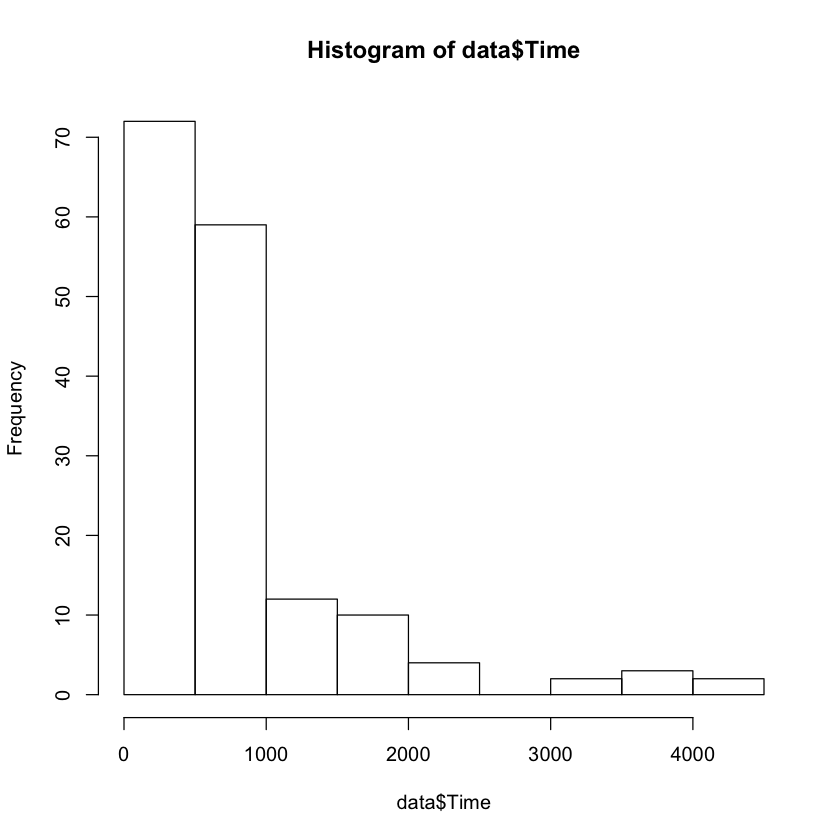

In [19]:
# well lets look at the histogram
hist(data$Time)

In [22]:
# However we chose to use a log representation (lot=log of time) of our data to account for 
lot <- log(data$Time)

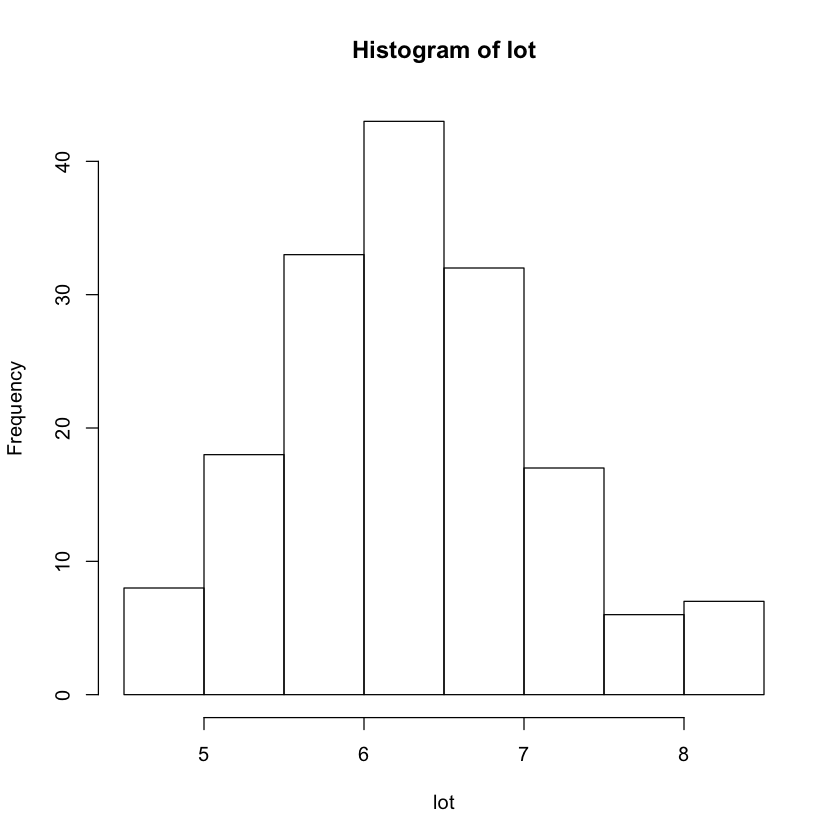

In [23]:
hist(lot)

This results in a nice bell-shaped cuve. So we can proceed with descriptives and a paired samples t-test so see initial differences in timing data. But first let's have a look at the box plots:

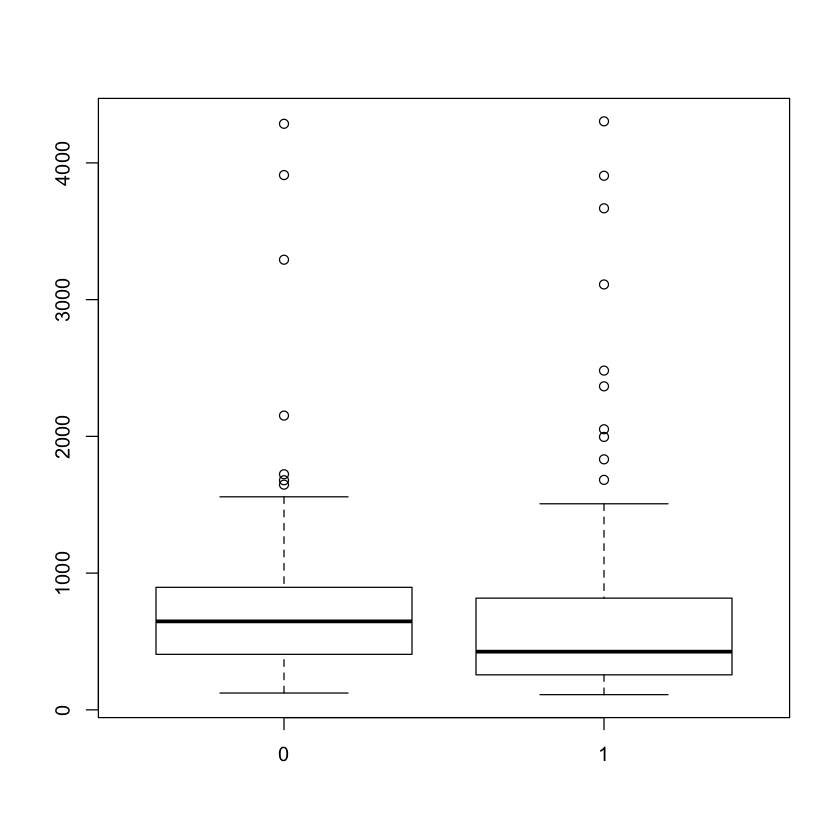

In [21]:
boxplot(data$Time~data$Condition)

Can't really see a signigicance between those two plots here. So perhaps a scatterplot will reveal more:

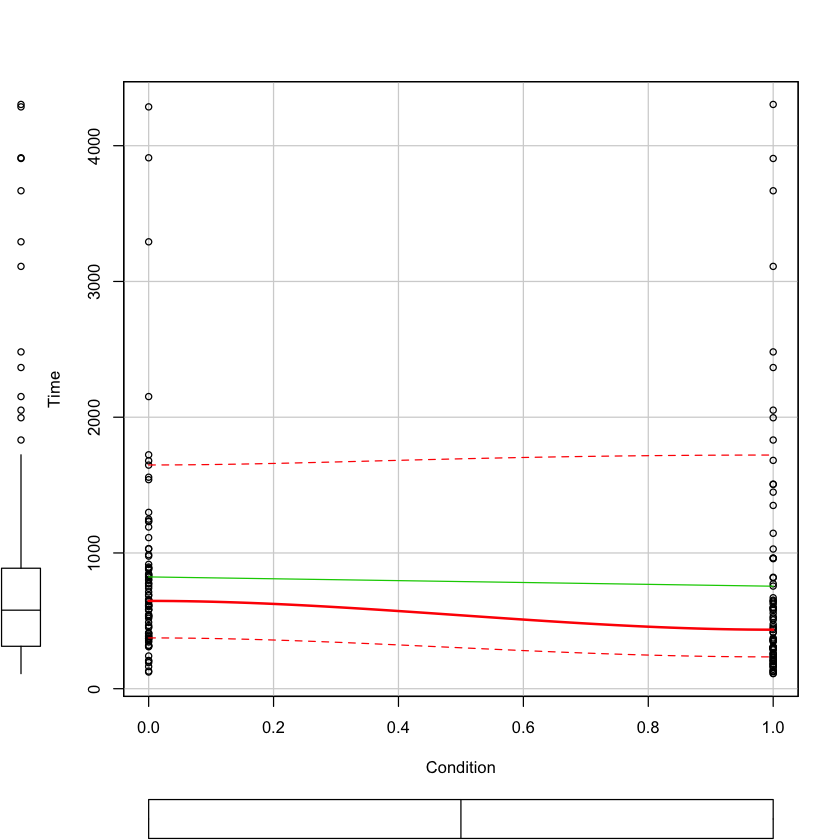

In [24]:
scatterplot(Time ~ Condition, data=data)

Eyeballing...there is a slight downward tendencey of time towards the MLR condition.

In [25]:
# Now the t-test (paired because our within-participants design)
t.test(data$Time, data$Condition, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  data$Time and data$Condition
t = 12.716, df = 163, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 666.3507 911.3566
sample estimates:
mean of the differences 
               788.8537 


Results show the t-test is highly significant - Hurray! 
The t-test shows that the two groups differ significatnly from each other $t(163) = 12.72, p < 0.01$

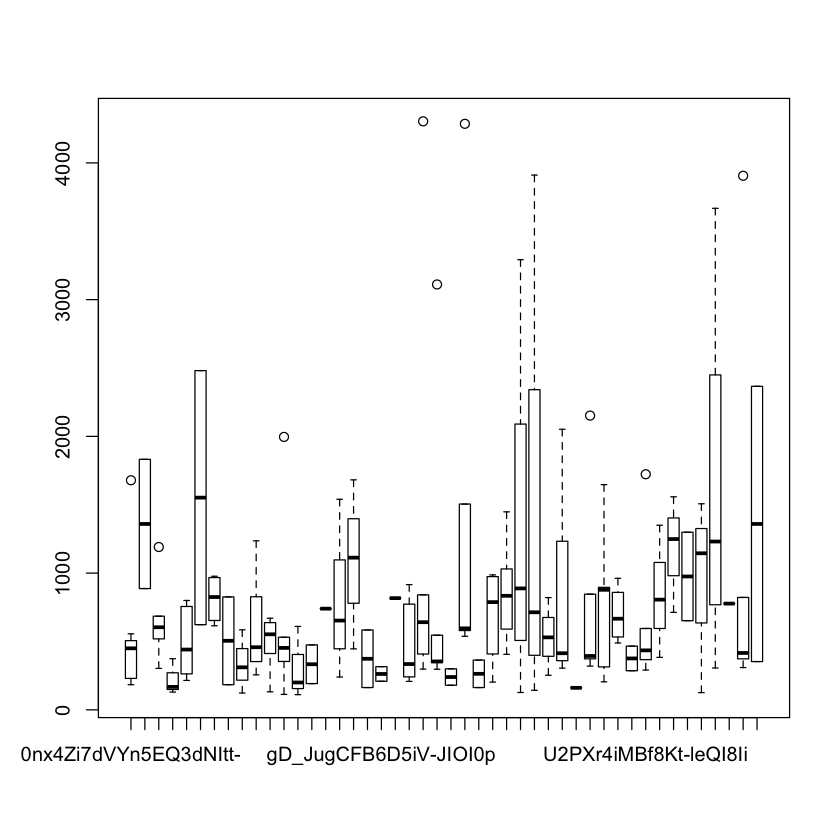

In [27]:
# before we carry on, lets have a look if there is a difference of timing in terms of the 
# documents. First the box plot:
boxplot(data$Time~data$PDF)

In [29]:
# Clearly some documents stand out in terms of time spent on them. Lets confirm that with
# a t-test:
t.test(data$Time, data$PDF, paired = TRUE, alternative = "two.sided")

Warning message in Ops.factor(x, y):
“‘-’ not meaningful for factors”

ERROR: Error in if (stderr < 10 * .Machine$double.eps * abs(mx)) stop("data are essentially constant"): missing value where TRUE/FALSE needed


PDF is a factor here - would need to transfer this. Let's do the same for timing in terms of the Order:

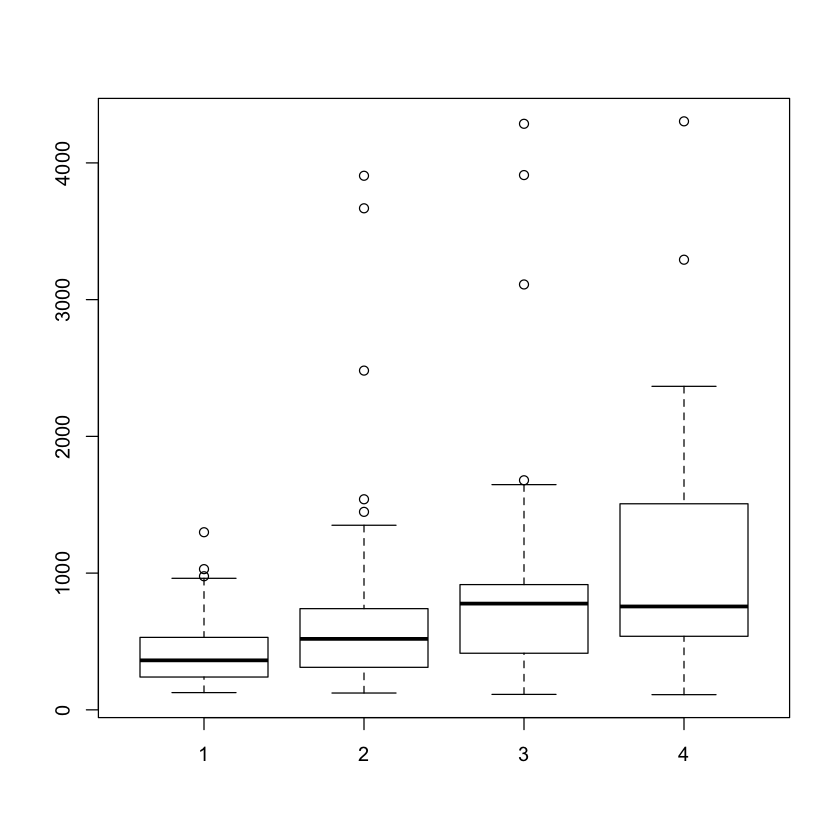

In [30]:
#First the box plot:
boxplot(data$Time~data$Order)

This nicely shows the incease in time spent on a PDF from the 1st Document participants see to the 4th.

In [31]:
# and the t-test:
t.test(data$Time, data$Order, paired = TRUE, alternative = "two.sided")


	Paired t-test

data:  data$Time and data$Order
t = 12.689, df = 163, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 664.4060 909.3013
sample estimates:
mean of the differences 
               786.8537 


The t-test shows that the two groups differ significantly from each other $t(163) = 12.69, p < 0.01$

In [38]:
# creating two groups (MLR and NML)
Annotations <- subset(data, Condition=='1')
NoAnnotations <- subset(data, Condition=='0')

In [39]:
# checking the data
head(Annotations)

,ParticipantNo,ID,PDF,Order,Time,Condition,CExperience,Tasks,NReviews,AMeanNReviews,Error
1,1,-JjAzwjQakZk-3kIbeMfw,U2PXr4iMBf8Kt-leQI8Ii,1,435,1,1,9,10+,12.5,0
3,1,-JjAzwjQakZk-3kIbeMfw,iHbGgWtrKNfksdoj9Hxv9,3,297,1,1,9,10+,12.5,0
5,2,hNQKTiKtHSY_BmxLyZb9Q,XOCbiBddVQK3BYy1Ox4lI,1,306,1,1,8,5to10,7.5,0
6,2,hNQKTiKtHSY_BmxLyZb9Q,oOAy7INgRLumTV3vZWtVM,2,127,1,1,8,5to10,7.5,0
10,3,pyTvUi2W85Nb9handPSvZ,gD_JugCFB6D5iV-JIOI0p,2,209,1,1,9,5to10,7.5,0
12,3,pyTvUi2W85Nb9handPSvZ,4gIe5sni3WJJCzNglSdo8,4,756,1,1,9,5to10,7.5,0


#### Descriptives

In [42]:
cat("Time Overall: ", sum(data$Time), '\n')
cat("Overall Mean Time: ", mean(data$Time), '\n')
cat("Overall SD Time: ", sd(data$Time), '\n')
cat('_____________________________________________', '\n')
cat("Time in Annotations: ", sum(Annotations$Time), "Time in NoAnnotations: ", sum(NoAnnotations$Time), '\n') 
cat("Mean Annotations: ", mean(Annotations$Time), "Mean NoAnnotations: ", mean(NoAnnotations$Time), '\n') 
cat("SD Annotations: ", sd(Annotations$Time), "SD NoAnnotations: ", sd(NoAnnotations$Time), '\n') 
cat('_____________________________________________', '\n')


Time Overall:  129454 
Overall Mean Time:  789.3537 
Overall SD Time:  794.4597 
_____________________________________________ 
Time in Annotations:  61913 Time in NoAnnotations:  67541 
Mean Annotations:  755.0366 Mean NoAnnotations:  823.6707 
SD Annotations:  868.4611 SD NoAnnotations:  716.6 
_____________________________________________ 


#### Linear Mixed Effects Model Analysis

In [43]:
# I think this was the primary modeal we agreed on last time (not taking into accoun the PDF):
ml.p = lmer(Time ~ Condition + (1 | ID), data=data)

In [45]:
summary(ml.p)

Linear mixed model fit by REML ['lmerMod']
Formula: Time ~ Condition + (1 | ID)
   Data: data

REML criterion at convergence: 2599.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1256 -0.4284 -0.1615  0.2437  4.2455 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 268159   517.8   
 Residual             369022   607.5   
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)   823.67     105.07   7.839
Condition     -68.63      94.87  -0.723

Correlation of Fixed Effects:
          (Intr)
Condition -0.451

#### Exploratory Analysis (Last Call)
Going back one step here and looking again at our data:

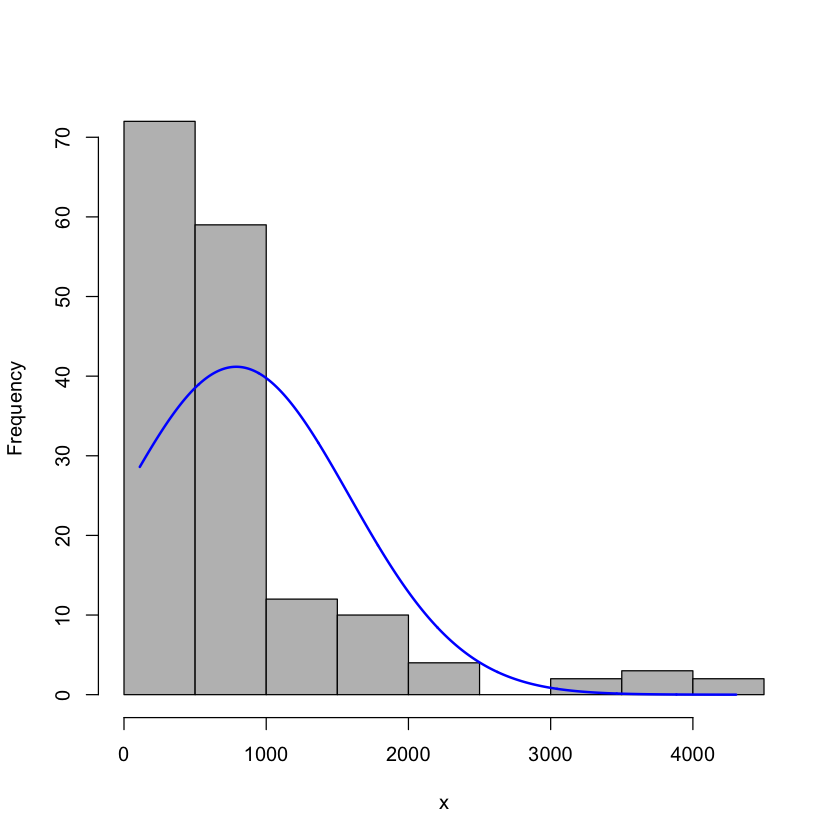

In [49]:
# first take a look at the normal data set:
plotNormalHistogram(data$Time)

In [46]:
# cheching the data transformation:
T_tuk = transformTukey(data$Time, plotit=FALSE)


    lambda      W Shapiro.p.value
395  -0.15 0.9907          0.3626

if (lambda >  0){TRANS = x ^ lambda} 
if (lambda == 0){TRANS = log(x)} 
if (lambda <  0){TRANS = -1 * x ^ lambda} 



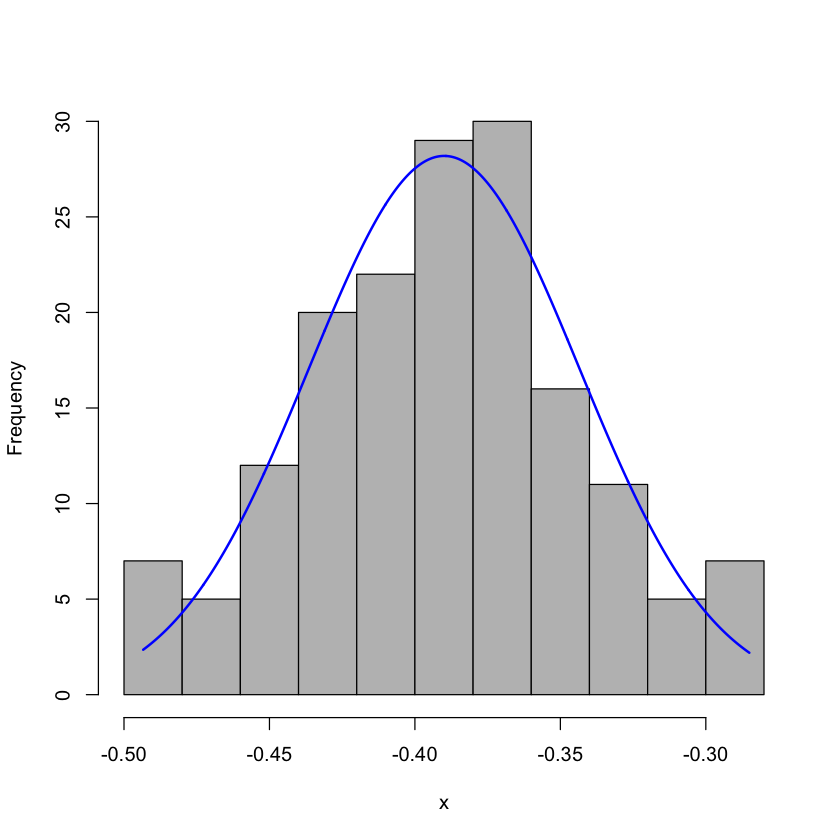

In [47]:
# plotting the data
plotNormalHistogram(T_tuk)

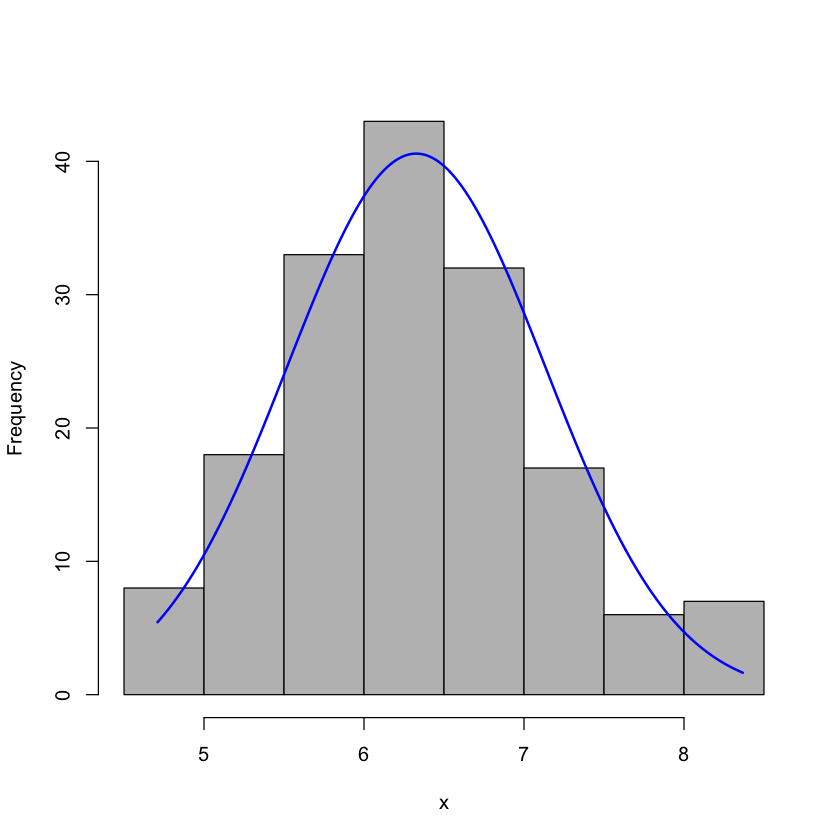

In [48]:
# Now using the log of the data and plotting it:
T_log <- log(data$Time)
plotNormalHistogram(T_log)

Comments on the above: If we do not use the completely transformed data then we do not have a very nice distribution as we have some timings that are quite large. The Lambda -0.15 is fine. One approach would be to just say we logged the data. Even if it is not optimal with the Shapiro-Wilk test - that is ok. The original model would suffer a bit more than the log would suffer. One version would be to say we just use the logged version because its more normally distributed. Then we keep the raw times as a secondary analysis to see if the results make sense. 

#### Now continuing with Exploratory Analisys (Likelyhood Ratio)

In [51]:
# we were wondering what is the effect of the PDF, Order, Condition and Person?
# first create log of Time data then create the models:
data$logT <- log(data$Time)
ml.1 = lmer(logT ~ Order + Condition + (1|ID) + (1|PDF), data=data, REML=FALSE)
ml.2 = lmer(logT ~ Condition + (1|ID) + (1|PDF), data=data, REML=FALSE)

In [52]:
anova(ml.1, ml.2)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.2,5,378.4641,393.9634,-184.2321,368.4641,NA,NA,NA
ml.1,6,338.1962,356.7954,-163.0981,326.1962,42.26793,1,7.958708e-11


This just tells us about the order.<br>
The anova says that the order is highly significant ($p<0.01$).<br>
That is an indication to keep the order in the model.<br>
The Order makes sense to keep as the first thing might make them take longer...<br>
Now lets take a look at model ml.1

In [53]:
summary(ml.1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (1 | ID) + (1 | PDF)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   338.2    356.8   -163.1    326.2      158 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.05956 -0.44213 -0.01847  0.60865  2.15485 

Random effects:
 Groups   Name        Variance Std.Dev.
 PDF      (Intercept) 0.02466  0.1571  
 ID       (Intercept) 0.23839  0.4883  
 Residual             0.27691  0.5262  
Number of obs: 164, groups:  PDF, 46; ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.78065    0.13809   41.86
Order        0.27151    0.03781    7.18
Condition   -0.27389    0.08498   -3.22

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.691       
Condition -0.319  0.012

We have a random intercept for every PDF.<br>
So we can see that the random effect variance of PDF is about 1/10th as high as the variance from the ID.<br>
So there is more variance across people than there is across PDF related.<br>
Lets do an ml.3 (removed the PDF random effect):

In [54]:
ml.3 = lmer(logT ~ Order + Condition + (1|ID), data=data, REML=FALSE)

In [55]:
# now looking at the anova for ml.1 and ml.3 :
anova(ml.1, ml.3)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.3,5,336.9199,352.4193,-163.4600,326.9199,NA,NA,NA
ml.1,6,338.1962,356.7954,-163.0981,326.1962,0.723746,1,0.3949179


NOT significant! This means we do not care so much for the PDF random effect.<br> 
In fact we could loose the PDF random effect without destroying the known universe.<br>
So lets see the random effects coefficients:

In [56]:
coef(ml.3)


$ID
                      (Intercept)     Order  Condition
-JjAzwjQakZk-3kIbeMfw    5.646676 0.2701334 -0.2765628
-O8MP5AR-esmcnFcENyoF    5.715102 0.2701334 -0.2765628
-YoLEIFk1XZUJo3BgVmlp    6.081139 0.2701334 -0.2765628
2K-K26QZH9xPJH9RVMltM    5.734187 0.2701334 -0.2765628
2snvok14kLm_dRIdL67PF    5.510783 0.2701334 -0.2765628
3CDOco99k3UGgia7A9LQo    6.710410 0.2701334 -0.2765628
4dkYUV8wlkm_Q5miw0qCJ    6.243188 0.2701334 -0.2765628
5h9rXuHepqDSmetOKXM0J    5.891452 0.2701334 -0.2765628
5SAqbCbqZP_q7hVWTEJdL    4.816425 0.2701334 -0.2765628
8arsi19w5sMwMmpkmM0sX    5.729063 0.2701334 -0.2765628
C07qGfUuD1L-1IoLjtOXY    5.908558 0.2701334 -0.2765628
C4xWyqDJrsHcIoHU5GtUG    6.429523 0.2701334 -0.2765628
Ci3GWDLAOc5ANxkPpNOBc    5.722301 0.2701334 -0.2765628
cs1qlmKFvdkFjUcXEkJgT    5.747713 0.2701334 -0.2765628
FfUZhXrHdKSHZ3ON2_Dty    6.016796 0.2701334 -0.2765628
fQoBVJ60uF5ehuYNAg4v2    5.732324 0.2701334 -0.2765628
FXvg7iTf7P1bl-Z9dHKPO    5.747617 0.2701334 -0.2765628
GR96Rb

In [57]:
summary(ml.3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (1 | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   336.9    352.4   -163.5    326.9      159 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.19339 -0.52439 -0.01335  0.53696  2.27474 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.2320   0.4817  
 Residual             0.3027   0.5501  
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.78920    0.13663   42.37
Order        0.27013    0.03843    7.03
Condition   -0.27656    0.08592   -3.22

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.707       
Condition -0.322  0.011

variance of coefficients 0.23<br>
Now, we are wondering whether different people may have a different coefficient when it comes to the Machine learning (random slope)<br>
One way to do that is to put condition also as random effect. So there is an overall mean for 
the machine learning, but how variable does it seem to be?

In [58]:
ml.3 = lmer(logT ~ Order + Condition + (Condition | ID), data=data, REML=FALSE)

In [59]:
summary(ml.3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   328.0    349.7   -157.0    314.0      157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3985 -0.4850  0.0052  0.5775  2.2962 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1487   0.3856       
          Condition   0.2000   0.4473   0.29
 Residual             0.2361   0.4859       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.76592    0.12264   47.01
Order        0.27940    0.03678    7.60
Condition   -0.27634    0.10314   -2.68

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.753       
Condition -0.138  0.009

So there seems to be variability in the slope.<br>
So different people seem to react differently to the machine learning condition. It seems that the residual variance has dropped between the two ml.3 models.<br>
It was .40 now it is .24? Maybe this model explains a bit more?<br>
Another thing to see is actually the coefficients:

In [60]:
# coefficients by ID
coef(ml.3)$ID 

,(Intercept),Order,Condition
-JjAzwjQakZk-3kIbeMfw,5.645644,0.2794002,-0.31868291
-O8MP5AR-esmcnFcENyoF,5.689063,0.2794002,-0.24591965
-YoLEIFk1XZUJo3BgVmlp,6.018559,0.2794002,-0.21255577
2K-K26QZH9xPJH9RVMltM,5.758266,0.2794002,-0.43458312
2snvok14kLm_dRIdL67PF,5.533983,0.2794002,-0.37010571
3CDOco99k3UGgia7A9LQo,6.471687,0.2794002,0.25956400
4dkYUV8wlkm_Q5miw0qCJ,6.085542,0.2794002,0.09094654
5h9rXuHepqDSmetOKXM0J,5.825058,0.2794002,-0.14658113
5SAqbCbqZP_q7hVWTEJdL,5.065488,0.2794002,-1.00634718
8arsi19w5sMwMmpkmM0sX,5.665417,0.2794002,-0.11211088


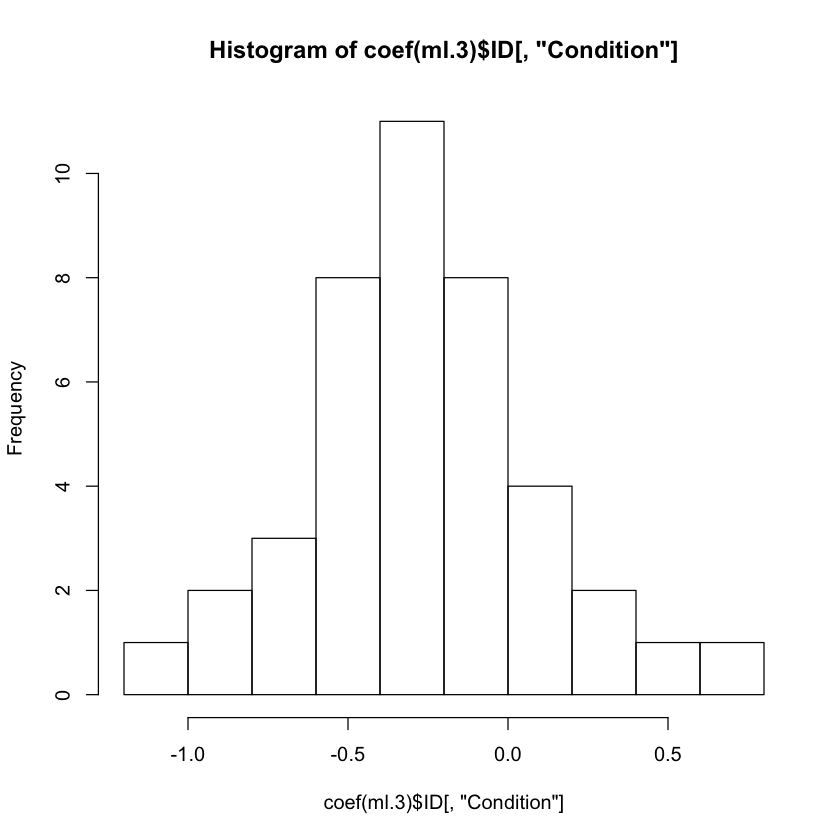

In [62]:
# histogram about those conditions:
hist(coef(ml.3)$ID[,"Condition"])

So there seems to be some people who do it faster and some slower so there seems to be some heterogeneity.<br>
ML.4 adds the random effect per person and it seems to be mattering


In [63]:
ml.4 = lmer(logT ~ Order + Condition + (Condition|ID), data=data, REML=FALSE)

In [64]:
anova(ml.4, ml.3)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.4,7,328.0184,349.7175,-157.0092,314.0184,NA,NA,NA
ml.3,7,328.0184,349.7175,-157.0092,314.0184,0,0,1


In [65]:
# Do we even need to Order if we have the condition as a random effect?
ml.5 = lmer(logT ~ Condition + (Condition|ID), data=data, REML=FALSE)

In [66]:
anova(ml.4, ml.5)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
ml.5,6,372.7248,391.3240,-180.3624,360.7248,NA,NA,NA
ml.4,7,328.0184,349.7175,-157.0092,314.0184,46.70645,1,8.245712e-12


Significant! Seems the order is still important.

In [67]:
summary(ml.4)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Order + Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   328.0    349.7   -157.0    314.0      157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3985 -0.4850  0.0052  0.5775  2.2962 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1487   0.3856       
          Condition   0.2000   0.4473   0.29
 Residual             0.2361   0.4859       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  5.76592    0.12264   47.01
Order        0.27940    0.03678    7.60
Condition   -0.27634    0.10314   -2.68

Correlation of Fixed Effects:
          (Intr) Order 
Order     -0.753       
Condition -0.138  0.009

In [68]:
summary(ml.5)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: logT ~ Condition + (Condition | ID)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   372.7    391.3   -180.4    360.7      158 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.34127 -0.62213  0.05227  0.57998  2.21132 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 ID       (Intercept) 0.1069   0.3270       
          Condition   0.1603   0.4003   0.52
 Residual             0.3708   0.6090       
Number of obs: 164, groups:  ID, 41

Fixed effects:
            Estimate Std. Error t value
(Intercept)  6.46783    0.08444   76.60
Condition   -0.28315    0.11381   -2.49

Correlation of Fixed Effects:
          (Intr)
Condition -0.298

Oh thats interesting both of them have the same variance with different sign (colinear?) Oh the order is not exactly random. 
Each individual has two of each!!! Its a random ordering. You will have for sure two ML and two non ML conditions. Maybe there is a constraint here. How do we model it? 
At best we throw the order out! <br><br>

After we throw the order out (ML5) the condition variance is roughly the same.
Before was -27 now is -28. But how big is it? This is Log?




In [69]:
exp(-.28)

[1] 0.7557837

= 0.76 = 75% of the time meaning 25% faster<br>
How much time it takes on average without machine learning in one model and the other one here is how you should interpret that in terms of practical things.


#### Further Options
change the outliers? truncate them?

#### Overall strategy:
First we take the crude analysis with the wilcoxon / t-test.<br>
The second was just the simple analysis with the condition the ID and the PDF into account.<br>
For the initial just the condition and the ID not PDF.<br> 
What is the machine learning over non machine learning for an individual and average those.<br> Which is equivalent to not a Random effect per individual but fixed intercepts per individual?<br>
What we want to show them is probably a table with coefficients ( go appendix) ?<br>
Perhaps an output of the difference in times actual predicted with and without machine learning.

## QUESTIONNAIRE ANALYSIS

In [70]:
# loading the data:
dataq <- read.xls("UXData1.xlsx", verbose=FALSE, na.strings=c("NA"))

In [72]:
# subsetting
data_rel <- as.data.frame(dataq)
ss2 <- c(1,3,4, 25:44)
data_q2 <- subset(data_rel, select=ss2)

In [73]:
# checking the data
head(data_q2)

ParticipantNo,Sequence,Condition,CapacityReview,NoOfTasksPerformed,HowManyReviews,CochraneRoBExp,UseFrequently,Complex,EasyToUse,⋯,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1010,A,develop questions; planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,9,10+,Yes,5,1,4,⋯,5,1,5,1,4,1,4,3,2,5
1,1010,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1100,A,planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,8,5to10,Yes,5,1,4,⋯,5,2,5,2,5,1,4,3,1,5
2,1100,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,101,A,develop questions; planning methods or write and publish protocols; develop and run search; select studies; collect data; assess RoB; analyse data; interprete findings; write and publish review,9,5to10,Yes,5,4,5,⋯,5,2,2,2,5,1,5,2,2,5
3,101,NOA,,NA,,,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [74]:
ss3 <- c(1, 3, 8:23)
clean_q2 <- subset(data_q2, select=ss3)
head(clean_q2)

ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
1,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
2,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
3,NOA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [75]:
clean_q2 <- subset(clean_q2, Condition=="A")

In [76]:
head(clean_q2)

,ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
3,2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
5,3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
7,4,A,5,2,5,4,5,2,5,5,4,2,5,2,4,2,2,5
9,5,A,5,2,5,2,5,1,4,1,4,1,3,1,3,3,2,4
11,6,A,5,3,3,3,2,4,5,2,1,1,2,5,5,1,2,5


In [77]:
clean_q2_A <- subset(clean_q2, Condition=='A')
clean_q2_NOA <- subset(clean_q2, Condition=='NOA')

In [78]:
head(clean_q2_A)

,ParticipantNo,Condition,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn,TextHelpful,DifficultToNav,ImproveQuality,Irrelevant,Confused,ContinueUse
1,1,A,5,1,4,1,4,2,5,1,5,1,4,1,4,3,2,5
3,2,A,5,1,4,1,5,1,5,2,5,2,5,1,4,3,1,5
5,3,A,5,4,5,2,5,2,5,2,2,2,5,1,5,2,2,5
7,4,A,5,2,5,4,5,2,5,5,4,2,5,2,4,2,2,5
9,5,A,5,2,5,2,5,1,4,1,4,1,3,1,3,3,2,4
11,6,A,5,3,3,3,2,4,5,2,1,1,2,5,5,1,2,5


In [79]:
str(clean_q2_A)

'data.frame':	41 obs. of  18 variables:
 $ ParticipantNo : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Condition     : Factor w/ 2 levels "A","NOA": 1 1 1 1 1 1 1 1 1 1 ...
 $ UseFrequently : int  5 5 5 5 5 5 4 1 2 4 ...
 $ Complex       : int  1 1 4 2 2 3 1 3 2 1 ...
 $ EasyToUse     : int  4 4 5 5 5 3 5 4 2 4 ...
 $ NeedSupport   : int  1 1 2 4 2 3 2 1 1 1 ...
 $ WellIntegrated: int  4 5 5 5 5 2 4 4 4 4 ...
 $ Inconsistency : int  2 1 2 2 1 4 3 1 3 1 ...
 $ UseQuickly    : int  5 5 5 5 4 5 4 3 3 4 ...
 $ Cumbersome    : int  1 2 2 5 1 2 2 4 2 1 ...
 $ Confident     : int  5 5 2 4 4 1 4 2 3 4 ...
 $ NeededLearn   : int  1 2 2 2 1 1 2 2 3 1 ...
 $ TextHelpful   : int  4 5 5 5 3 2 3 5 4 3 ...
 $ DifficultToNav: int  1 1 1 2 1 5 2 3 1 1 ...
 $ ImproveQuality: int  4 4 5 4 3 5 3 3 5 2 ...
 $ Irrelevant    : int  3 3 2 2 3 1 4 2 2 4 ...
 $ Confused      : int  2 1 2 2 2 2 3 2 2 4 ...
 $ ContinueUse   : int  5 5 5 5 4 5 4 4 2 4 ...


In [80]:
# need to change this to factors!
clean_q2_A$UseFrequently = factor(clean_q2_A$UseFrequently,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Complex = factor(clean_q2_A$Complex,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$EasyToUse = factor(clean_q2_A$EasyToUse,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$NeedSupport = factor(clean_q2_A$NeedSupport,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$WellIntegrated = factor(clean_q2_A$WellIntegrated,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Inconsistency = factor(clean_q2_A$Inconsistency,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$UseQuickly = factor(clean_q2_A$UseQuickly,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Cumbersome = factor(clean_q2_A$Cumbersome,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Confident = factor(clean_q2_A$Confident,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$NeededLearn = factor(clean_q2_A$NeededLearn,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$TextHelpful = factor(clean_q2_A$TextHelpful,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$DifficultToNav = factor(clean_q2_A$DifficultToNav,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$ImproveQuality = factor(clean_q2_A$ImproveQuality,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Irrelevant = factor(clean_q2_A$Irrelevant,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$Confused = factor(clean_q2_A$Confused,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

clean_q2_A$ContinueUse = factor(clean_q2_A$ContinueUse,
                                  levels = c("1", "2", "3", "4", "5"), ordered = TRUE)

In [81]:
# checkl again
str(clean_q2_A)

'data.frame':	41 obs. of  18 variables:
 $ ParticipantNo : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Condition     : Factor w/ 2 levels "A","NOA": 1 1 1 1 1 1 1 1 1 1 ...
 $ UseFrequently : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 5 5 5 5 4 1 2 4 ...
 $ Complex       : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 1 4 2 2 3 1 3 2 1 ...
 $ EasyToUse     : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 4 4 5 5 5 3 5 4 2 4 ...
 $ NeedSupport   : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 1 2 4 2 3 2 1 1 1 ...
 $ WellIntegrated: Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 4 5 5 5 5 2 4 4 4 4 ...
 $ Inconsistency : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 2 1 2 2 1 4 3 1 3 1 ...
 $ UseQuickly    : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 5 5 4 5 4 3 3 4 ...
 $ Cumbersome    : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 2 2 5 1 2 2 4 2 1 ...
 $ Confident     : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 5 5 2 4 4 1 4 2 3 4 ...
 $ NeededLearn   : Ord.factor w/ 5 levels "1"<"2"<"3"<"4"<..: 1 

In [82]:
summary(clean_q2_A)

 ParticipantNo Condition UseFrequently Complex   EasyToUse NeedSupport
 Min.   : 1    A  :41    1   : 1       1   :24   1   : 3   1   :25    
 1st Qu.:11    NOA: 0    2   : 5       2   :10   2   : 1   2   :11    
 Median :21              3   : 8       3   : 4   3   : 6   3   : 2    
 Mean   :21              4   :10       4   : 1   4   :13   4   : 1    
 3rd Qu.:31              5   :15       5   : 0   5   :16   5   : 0    
 Max.   :41              NA's: 2       NA's: 2   NA's: 2   NA's: 2    
 WellIntegrated Inconsistency UseQuickly Cumbersome Confident NeededLearn
 1   : 1        1   :15       1   : 0    1   :20    1   : 2   1   :17    
 2   : 2        2   :13       2   : 2    2   :11    2   : 5   2   :15    
 3   : 7        3   : 7       3   : 2    3   : 5    3   : 8   3   : 3    
 4   :17        4   : 4       4   :17    4   : 2    4   :12   4   : 2    
 5   :12        5   : 0       5   :18    5   : 1    5   :12   5   : 2    
 NA's: 2        NA's: 2       NA's: 2    NA's: 2    NA's: 2

In [83]:
#need to remove the 'out of level columns'
ss4 <- c(3:18)
final_data <- subset(clean_q2_A, select=ss4)
summary(final_data)

 UseFrequently Complex   EasyToUse NeedSupport WellIntegrated Inconsistency
 1   : 1       1   :24   1   : 3   1   :25     1   : 1        1   :15      
 2   : 5       2   :10   2   : 1   2   :11     2   : 2        2   :13      
 3   : 8       3   : 4   3   : 6   3   : 2     3   : 7        3   : 7      
 4   :10       4   : 1   4   :13   4   : 1     4   :17        4   : 4      
 5   :15       5   : 0   5   :16   5   : 0     5   :12        5   : 0      
 NA's: 2       NA's: 2   NA's: 2   NA's: 2     NA's: 2        NA's: 2      
 UseQuickly Cumbersome Confident NeededLearn TextHelpful DifficultToNav
 1   : 0    1   :20    1   : 2   1   :17     1   : 1     1   :24       
 2   : 2    2   :11    2   : 5   2   :15     2   : 4     2   : 7       
 3   : 2    3   : 5    3   : 8   3   : 3     3   :12     3   : 4       
 4   :17    4   : 2    4   :12   4   : 2     4   :12     4   : 3       
 5   :18    5   : 1    5   :12   5   : 2     5   :10     5   : 1       
 NA's: 2    NA's: 2    NA's: 2   NA'

In [84]:
results <- likert(final_data)

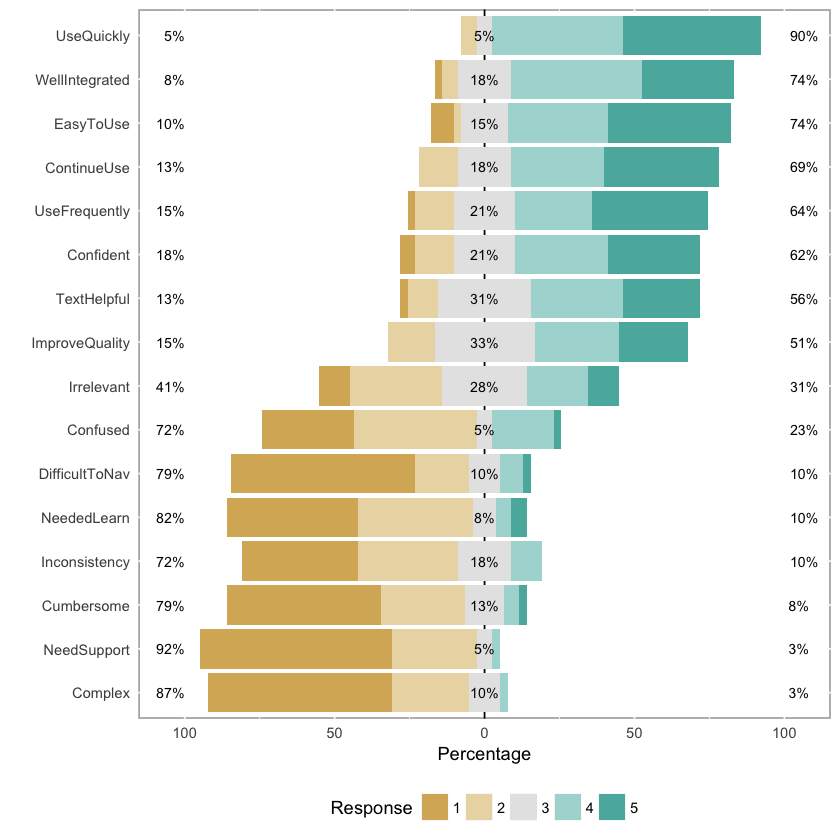

In [85]:
# Remember: 5 = Strongly agree 1 = Stronly disagree
plot(results, type='bar')

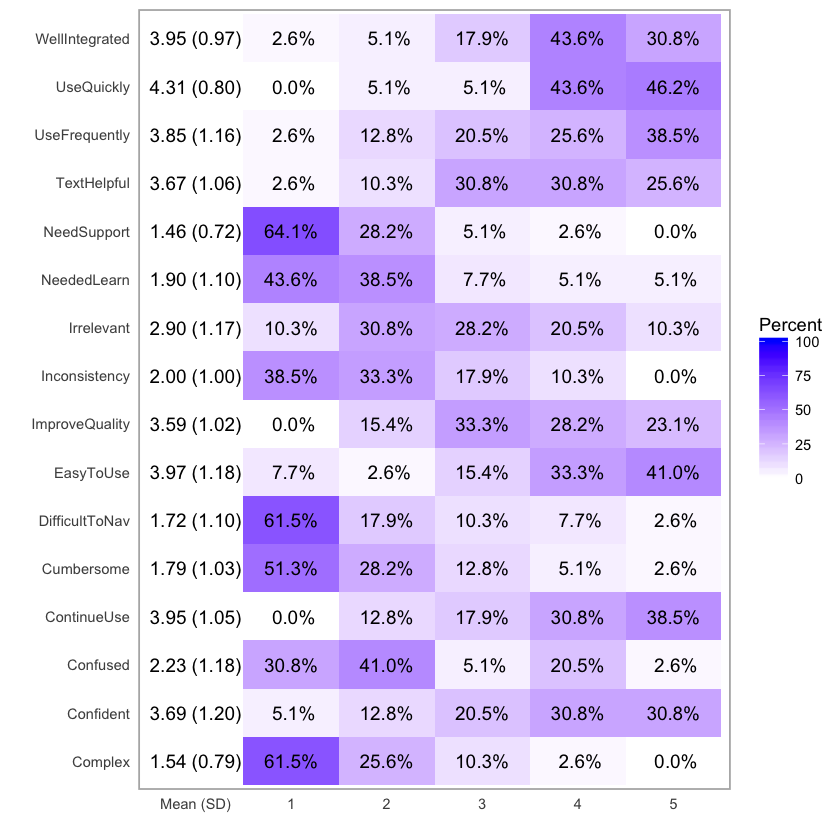

In [86]:
# check this in heatmap
plot(results, 
     type="heat",
           low.color = "white", 
           high.color = "blue",
           text.color = "black", 
           text.size = 4, 
           wrap = 50)

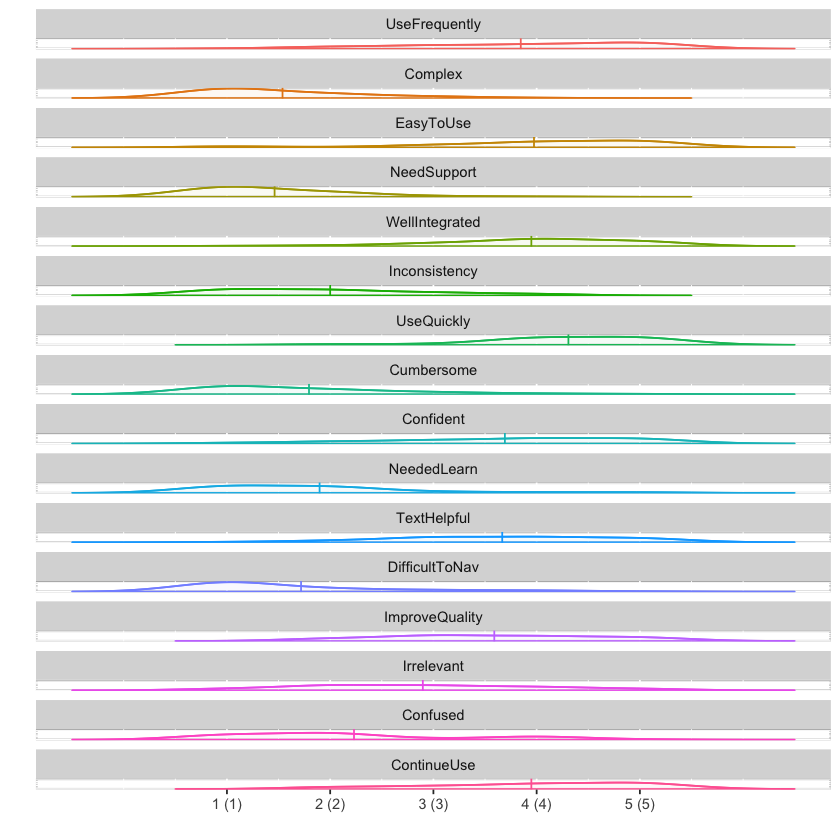

In [87]:
# checkng the distributions
plot(results,
     type="density",
           facet = TRUE, 
           bw = 0.5)

Jason Bryer, J. and Speerschneider, K. Package ‘likert’. cran.r-project.org/web/packages/likert/likert.pdf.

#### System Usability Score Evaluation

In [88]:
r1 <- c(1, 3:12)
sus <- subset(clean_q2_A, select=r1)
head(sus)

,ParticipantNo,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn
1,1,5,1,4,1,4,2,5,1,5,1
3,2,5,1,4,1,5,1,5,2,5,2
5,3,5,4,5,2,5,2,5,2,2,2
7,4,5,2,5,4,5,2,5,5,4,2
9,5,5,2,5,2,5,1,4,1,4,1
11,6,5,3,3,3,2,4,5,2,1,1


In [89]:
sus

,ParticipantNo,UseFrequently,Complex,EasyToUse,NeedSupport,WellIntegrated,Inconsistency,UseQuickly,Cumbersome,Confident,NeededLearn
1,1,5,1,4,1,4,2,5,1,5,1
3,2,5,1,4,1,5,1,5,2,5,2
5,3,5,4,5,2,5,2,5,2,2,2
7,4,5,2,5,4,5,2,5,5,4,2
9,5,5,2,5,2,5,1,4,1,4,1
11,6,5,3,3,3,2,4,5,2,1,1
13,7,4,1,5,2,4,3,4,2,4,2
15,8,1,3,4,1,4,1,3,4,2,2
17,9,2,2,2,1,4,3,3,2,3,3
19,10,4,1,4,1,4,1,4,1,4,1


In [90]:
sus_ready <- read.csv("sus_calculation.csv")

In [91]:
head(sus_ready)

Participant,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,SUS.Score
1,5,1,4,1,4,2,5,1,5,1,92.5
2,5,1,4,1,5,1,5,2,5,2,92.5
3,5,4,5,2,5,2,5,2,2,2,75.0
4,5,2,5,4,5,2,5,5,4,2,72.5
5,5,2,5,2,5,1,4,1,4,1,90.0
6,5,3,3,3,2,4,5,2,1,1,57.5


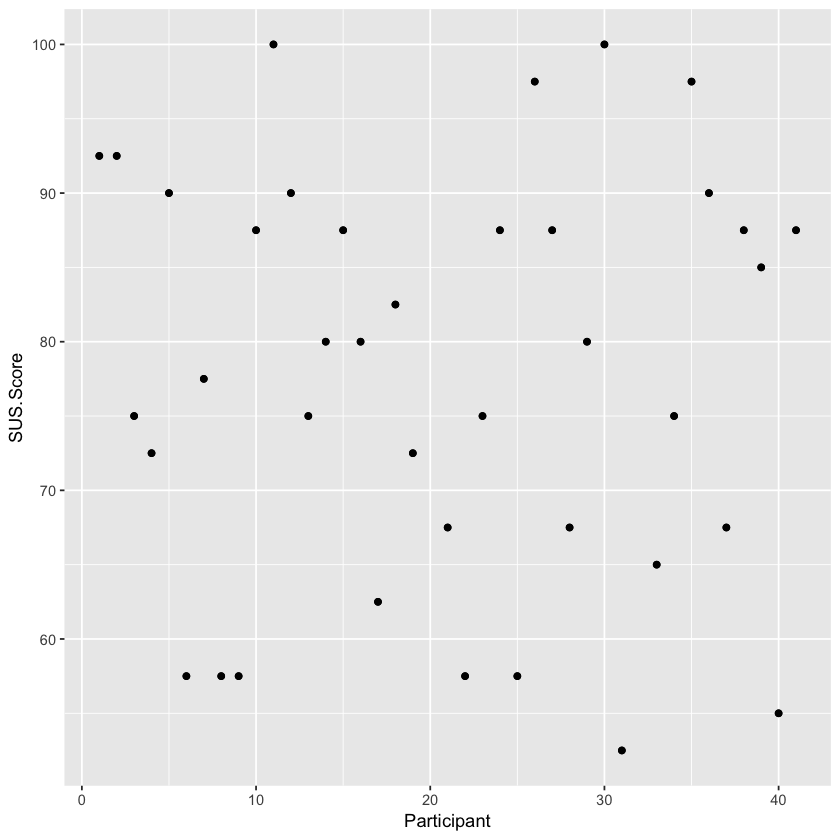

In [92]:
g <- c(2:11)
ggplot(data=sus_ready, aes(x=Participant, y=SUS.Score, group=1)) +
  geom_point()+
  geom_point()

In [93]:
mean(sus_ready$SUS.Score)

[1] 77.69231

The actual SUS calculation is in <b>sus_calculation.xlsx</b><br>
From what I found out SUS: $60-70=ok$, $70-80=good$, $80+ =excellent$